In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

import os
from tqdm import tqdm
import itertools

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [2]:
data_ds = "../input/aicup-crops"
classes = os.listdir(data_ds)
print(classes)

['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']


In [3]:
import shutil

# shutil.rmtree('/kaggle/temp/')
    
valid_num = 300

for aclass in classes:
    src_ds = os.path.join(data_ds, aclass)
    train_cd = os.path.join('/kaggle/temp/train', aclass)
    valid_cd = os.path.join('/kaggle/temp/valid', aclass)
    os.makedirs(train_cd)
    os.makedirs(valid_cd)
    
    files = os.listdir(src_ds)
    for f in tqdm(files[valid_num:]):
        src = os.path.join(src_ds, f)
        dst = os.path.join(train_cd, f)
        shutil.copy(src, dst)
    for f in files[:valid_num]:
        src = os.path.join(src_ds, f)
        dst = os.path.join(valid_cd, f)
        shutil.copy(src, dst)

100%|██████████| 7650/7650 [00:53<00:00, 142.89it/s]


In [4]:
transforms = T.Compose([
    T.Resize((360, 360)),
#     T.RandomEqualize(p=1),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
train_ds = ImageFolder('/kaggle/temp/train', transform = transforms)
val_ds = ImageFolder('/kaggle/temp/valid', transform = transforms)
#test_ds

In [5]:
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
len(train_ds), len(val_ds) #, len(test_ds)

(76035, 4200)

In [7]:
batch_size = 32

In [8]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2)
#test_dl = DataLoader(val_ds, batch_size*2, num_workers = 2)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

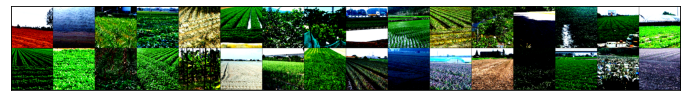

In [10]:
show_batch(train_dl)

跑GPU

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
#改batch

In [12]:
device = get_default_device()
device

device(type='cuda')

Train model的函式

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def predict_step(self, batch, y_pred, y_true):
        images, labels = batch 
        out = self(images)  # Generate predictions
        _, preds = torch.max(out, 1)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
        y_true.extend(labels.view(-1).detach().cpu().numpy())      # target是ground-truth的label
        #acc = accuracy(out, labels)           # Calculate accuracy
        return y_pred, y_true
        #return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        torch.save(self.network.state_dict(), '/kaggle/working/model-' + str(epoch) + '.pth')
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
@torch.no_grad()
def predict(model, val_loader, y_pred, y_true):
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader):
            y_pred, y_true=model.predict_step(batch, y_pred, y_true)
        #outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return y_pred, y_true

def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, y_pred, y_true, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        predict(model, val_dl, y_pred, y_true )
        target_names = ['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
        cnf_matrix = confusion_matrix(y_true, y_pred)
        per_cls_acc = cnf_matrix.diagonal()/cnf_matrix.sum(axis=0)                    # https://stackoverflow.com/a/53824126/13369757
        print(target_names)
        print(per_cls_acc)                                                          #顯示每個class的Accuracy
        print("Plot confusion matrix")

        # 開始繪製混淆矩陣
        df_cm = pd.DataFrame(cnf_matrix, target_names, target_names)     # https://sofiadutta.github.io/datascience-ipynbs/pytorch/Image-Classification-using-PyTorch.html
        plt.figure(figsize = (15,15))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        y_pred=[]
        y_true=[]
    return history

In [15]:
class EfficientNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = timm.create_model('efficientnet_b0', pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Linear(num_ftrs, len(train_ds.classes))
    
    def forward(self, xb):
        return self.network(xb)

model = EfficientNet()


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

EfficientNet(
  (network): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

In [17]:
model = to_device(EfficientNet(), device)
#evaluate(model, val_dl)

In [18]:
y_pred=[]
y_true=[]

100%|██████████| 66/66 [01:03<00:00,  1.04it/s]


Epoch 1: train_loss: 0.1588, val_loss: 0.0871, val_acc: 0.9727


100%|██████████| 66/66 [01:01<00:00,  1.07it/s]


['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
[0.99003322 0.95779221 0.98630137 0.96688742 0.98349835 0.97385621
 0.99662162 0.88461538 0.97704918 0.99298246 0.98675497 0.9540636
 1.         0.98293515]
Plot confusion matrix


100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


Epoch 2: train_loss: 0.0664, val_loss: 0.0750, val_acc: 0.9794


100%|██████████| 66/66 [01:02<00:00,  1.06it/s]


['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
[0.99006623 0.94888179 0.99315068 0.96710526 0.99331104 0.94637224
 0.99333333 0.95723684 0.99333333 0.98965517 0.98679868 0.97250859
 0.98986486 0.99653979]
Plot confusion matrix


100%|██████████| 66/66 [01:03<00:00,  1.04it/s]


Epoch 3: train_loss: 0.0475, val_loss: 0.1041, val_acc: 0.9689


100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
[0.97087379 0.94936709 1.         0.96732026 0.99       0.9054878
 0.98013245 0.92767296 0.98671096 0.97887324 0.98671096 0.95945946
 1.         0.97923875]
Plot confusion matrix


100%|██████████| 66/66 [01:03<00:00,  1.04it/s]


Epoch 4: train_loss: 0.0381, val_loss: 0.0859, val_acc: 0.9764


100%|██████████| 66/66 [01:02<00:00,  1.05it/s]


['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
[0.99335548 0.97039474 0.98333333 0.97342193 1.         0.96774194
 0.98996656 0.94174757 0.99666667 0.98550725 0.98026316 0.91346154
 0.99333333 0.98954704]
Plot confusion matrix


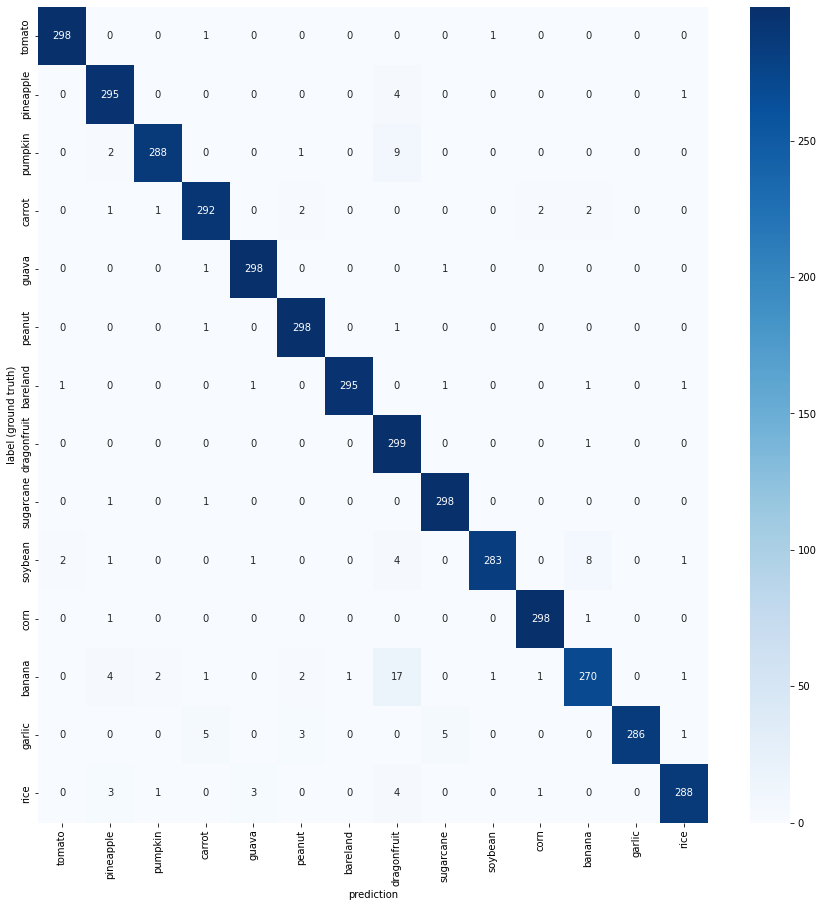

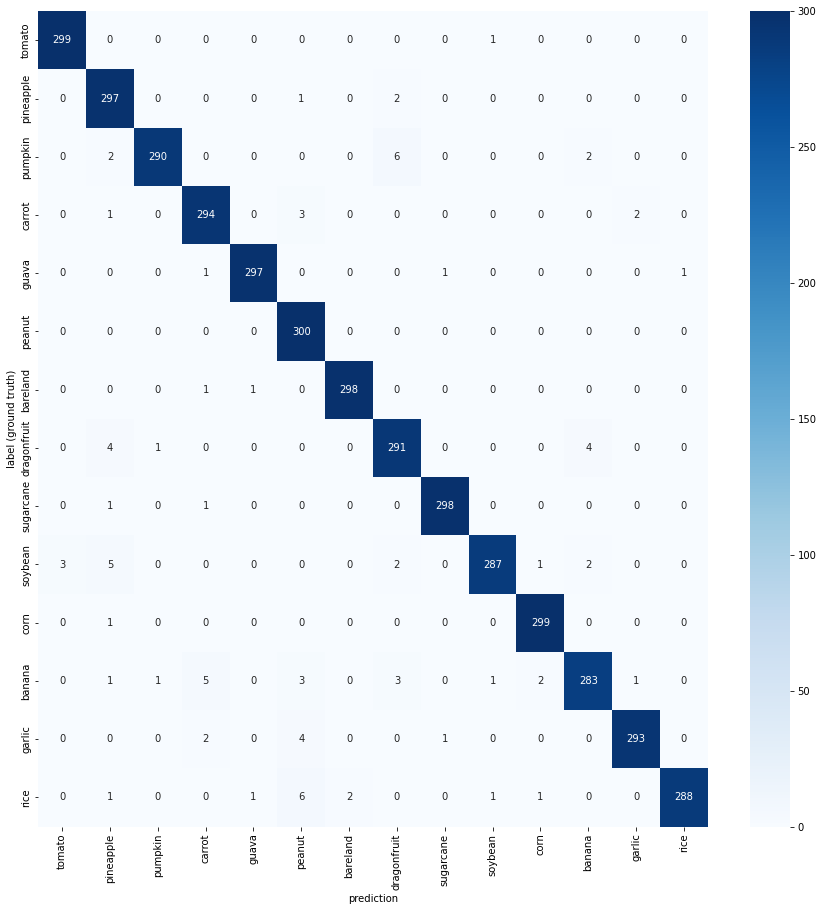

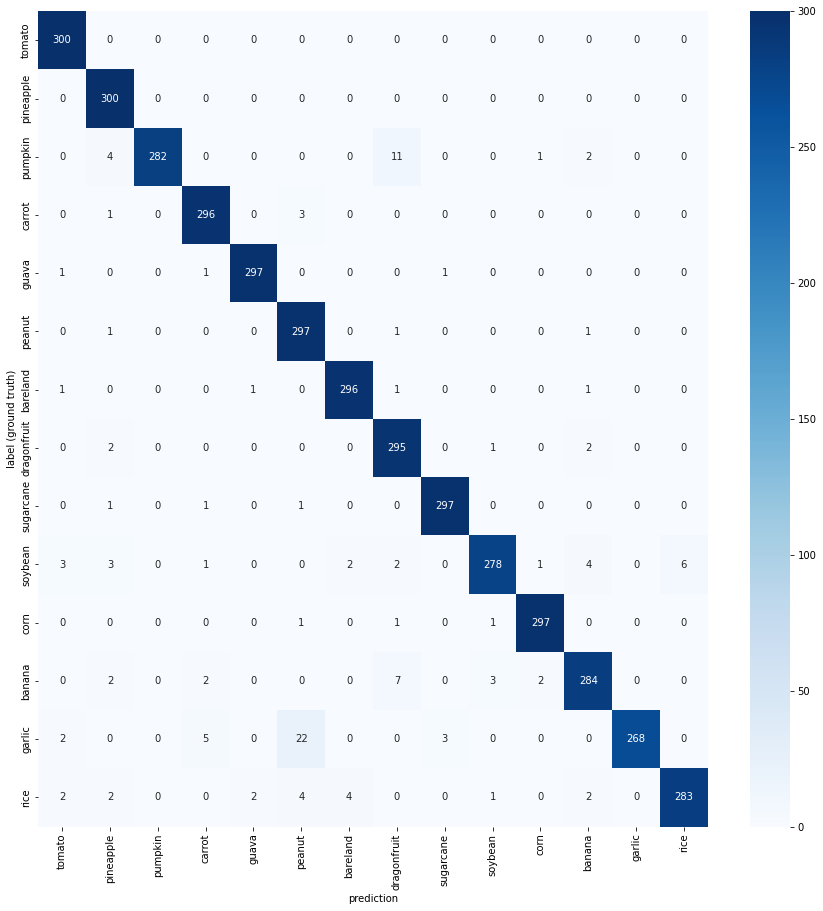

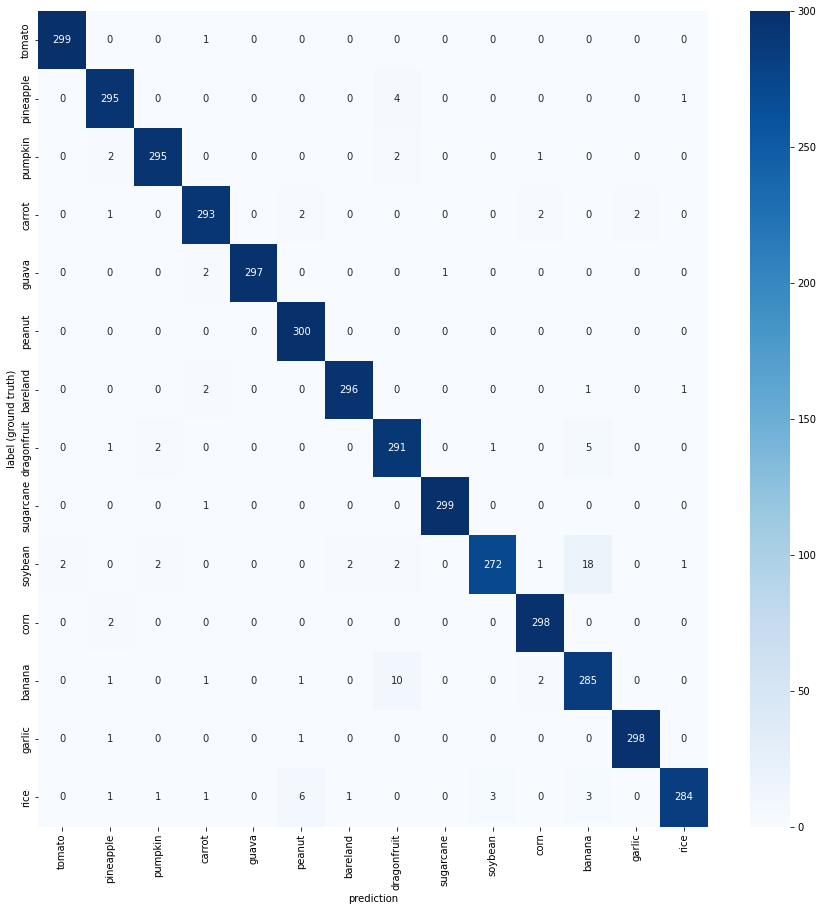

In [19]:
num_epochs = 4
opt_func = torch.optim.AdamW
lr = 3e-4

history = fit(num_epochs, lr, model, train_dl, val_dl, y_pred, y_true, opt_func)


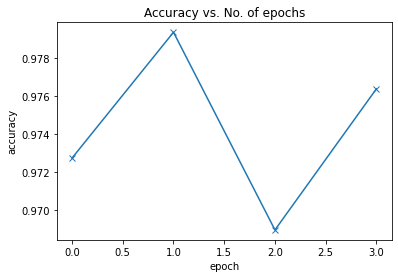

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

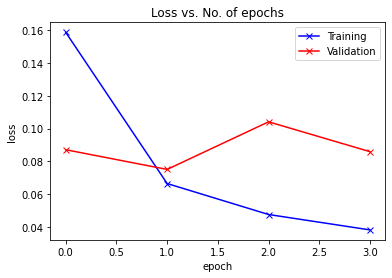

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [22]:
# def predict_image(img, model):
#     # Convert to a batch of 1
#     xb = to_device(img.unsqueeze(0), device)
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     prob, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label
#     return train_ds.classes[preds[0].item()]

測試test